In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings('ignore', category=UserWarning, message="Line Search failed")

In [36]:
#load data and preprocess
data = pd.read_csv('final_result1.csv').fillna(0)
print(data.head())
print(data.isnull().sum())

  geneName      baseMean  log2FoldChange     lfcSE       stat         pvalue  \
0        T  1.210066e-01       -0.013028  2.462744  -0.005290   9.957793e-01   
1      APP  2.176968e+05      -14.159003  0.563238 -25.138599  1.880000e-139   
2    CASP2  1.621671e+06       18.059613  0.955149  18.907637   9.870000e-80   
3    ORAI2  3.601909e+05       17.374789  0.988970  17.568574   4.290000e-69   
4    SYPL1  3.249794e+05       14.789948  0.881834  16.771802   3.920000e-63   

            padj  NSCLC  SCLC  
0   0.000000e+00      0     0  
1  1.500000e-135      0     0  
2   3.930000e-76      0     0  
3   1.140000e-65      0     0  
4   7.820000e-60      0     0  
geneName          0
baseMean          0
log2FoldChange    0
lfcSE             0
stat              0
pvalue            0
padj              0
NSCLC             0
SCLC              0
dtype: int64


In [37]:
#feature selection
features = data[['baseMean', 'log2FoldChange', 'pvalue']]
targets = {'NSCLC': data['NSCLC'], 'SCLC': data['SCLC']}

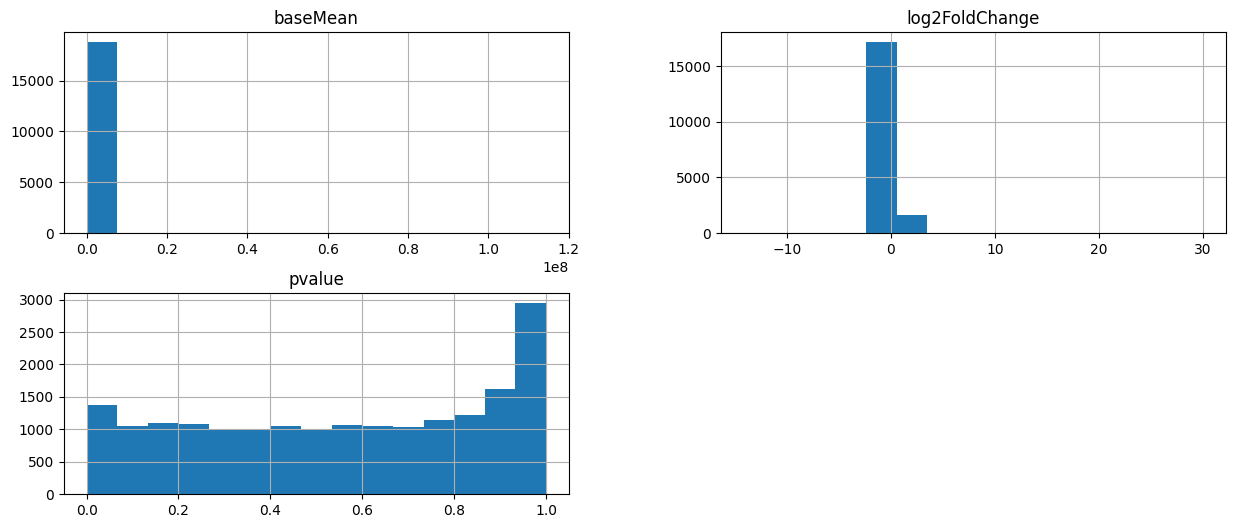

In [39]:
#EDA
#histograms and correlation matrix
features.hist(bins=15, figsize=(15, 6), layout=(2, 2))
plt.show()

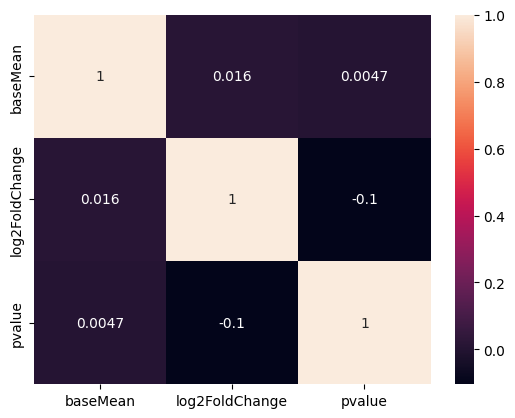

In [40]:
sns.heatmap(features.corr(), annot=True)
plt.show()

In [41]:
#SMOTE and Data Splitting
def split_and_resample(features, target, test_size=0.4, random_state=42):
    x_train, x_temp, y_train, y_temp = train_test_split(features, target, test_size=test_size, random_state=random_state)
    smote = SMOTE()
    x_train_res, y_train_res = smote.fit_resample(x_train, y_train)
    x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=random_state)
    return x_train_res, x_test, x_val, y_train_res, y_test, y_val

data_nsclc = split_and_resample(features, targets['NSCLC'])
data_sclc = split_and_resample(features, targets['SCLC'])

In [42]:
#logistic regression pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=10000))
])

In [43]:
#parameter grid
param_grid_lr = [
    {'lr__penalty': ['l1', 'l2'], 'lr__C': np.logspace(-4, 4, 10), 'lr__solver': ['liblinear'], 'lr__tol': [1e-3]},
    {'lr__penalty': ['l2'], 'lr__C': np.logspace(-4, 4, 10), 'lr__solver': ['lbfgs', 'newton-cg', 'sag'], 'lr__tol': [1e-3]},
    {'lr__penalty': ['elasticnet'], 'lr__C': np.logspace(-4, 4, 10), 'lr__solver': ['saga'], 'lr__l1_ratio': np.linspace(0, 1, 10), 'lr__tol': [1e-3]}
]

In [44]:
#function for GridSearchCV and model evaluation
def evaluate_logistic_regression(data, param_grid):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(data[0], data[3])  #fit on training data
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_lr = pipeline.set_params(**best_params)
    best_lr.fit(data[0], data[3])  # refit on training data
    y_val_pred = best_lr.predict(data[2])  #predict on validation data
    report = classification_report(data[5], y_val_pred)
    return best_params, best_score, report

In [45]:
#evaluate for NSCLC
best_params_nsclc, best_score_nsclc, report_nsclc = evaluate_logistic_regression(data_nsclc, param_grid_lr)
print("Best Parameters for NSCLC:", best_params_nsclc)
print("Best F1 Score for NSCLC:", best_score_nsclc)
print("Classification Report for NSCLC (Validation Data):\n", report_nsclc)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineS

Best Parameters for NSCLC: {'lr__C': 0.000774263682681127, 'lr__l1_ratio': 0.2222222222222222, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'lr__tol': 0.001}
Best F1 Score for NSCLC: 0.43897803107683986
Classification Report for NSCLC (Validation Data):
               precision    recall  f1-score   support

           0       0.99      0.61      0.75      3741
           1       0.00      0.24      0.01        21

    accuracy                           0.60      3762
   macro avg       0.50      0.42      0.38      3762
weighted avg       0.99      0.60      0.75      3762



/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [46]:
#evaluate for SCLC
best_params_sclc, best_score_sclc, report_sclc = evaluate_logistic_regression(data_sclc, param_grid_lr)
print("Best Parameters for SCLC:", best_params_sclc)
print("Best F1 Score for SCLC:", best_score_sclc)
print("Classification Report for SCLC (Validation Data):\n", report_sclc)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty i

Best Parameters for SCLC: {'lr__C': 0.0001, 'lr__l1_ratio': 0.1111111111111111, 'lr__penalty': 'elasticnet', 'lr__solver': 'saga', 'lr__tol': 0.001}
Best F1 Score for SCLC: 0.5787049257207568
Classification Report for SCLC (Validation Data):
               precision    recall  f1-score   support

           0       0.99      0.54      0.70      3738
           1       0.01      0.42      0.01        24

    accuracy                           0.54      3762
   macro avg       0.50      0.48      0.36      3762
weighted avg       0.99      0.54      0.70      3762



/Users/anokhiharia/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
